## ML - Fitting a scikit-learn regressor on EC2
### Milestone 3 - Task 3
### DSCI 525 - Group 10


In [31]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd

# Modelling
from joblib import dump, load
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Visuals
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 8, 'axes.labelweight': 'bold', 'figure.figsize': (8,6)})

### Overview

In our previous step (notebooks/02-ml_preprocessing.ipynb) we have read  in multiple weather model forecasts for Australia from parquet files, trim to Sydney forecasts and then join on actual observed rainfall data. We aggregated to *mean* daily rainfall from the models to compare to actuals. The final data frame has a separate column for each weather model to be used for machine learning modelling of the actual rainfall in Sydney. The target column is `observed_rainfall`.

We will read in this dataset from our S3 bucket, drop NA's and do a 80/20% train/test split. We will then compare RMSE error from the raw weather model predictions vs. an ensemble machine learning method.

In [2]:
# INPUTS ------------------------------------------
# path_to_input_datasets = "/srv/data/my_shared_data_folder/"
path_to_input = "s3://mds-s3-student71/output/"

# path_to_output = "/srv/data/my_shared_data_folder/"
# path_to_output = "s3://mds-s3-student71/output/"



In [5]:
df_modelling = pd.read_csv(os.path.join(path_to_input, "ml_data_SYD.csv"), index_col=0, parse_dates=True)

In [6]:
df_modelling

,ACCESS-CM2,ACCESS-ESM1-5,AWI-ESM-1-1-LR,BCC-CSM2-MR,BCC-ESM1,CMCC-CM2-HR4,CMCC-CM2-SR5,CMCC-ESM2,CanESM5,EC-Earth3-Veg-LR,...,MPI-ESM-1-2-HAM,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,SAM0-UNICON,TaiESM1,observed_rainfall
time,,,,,,,,,,,,,,,,,,,,,
1889-01-01,0.040427,1.814552,3.557934e+01,4.268112e+00,1.107466e-03,1.141054e+01,3.322009e-08,2.668800,1.321215,1.515293,...,4.244226e-13,1.390174e-13,6.537884e-05,3.445495e-06,1.576096e+01,4.759651e-05,2.451075,0.221324,2.257933,0.006612
1889-01-02,0.073777,0.303965,4.596520e+00,1.190141e+00,1.015323e-04,4.014984e+00,1.312700e+00,0.946211,2.788724,4.771375,...,4.409552e+00,1.222283e-01,1.049131e-13,4.791993e-09,3.675510e-01,4.350863e-01,0.477231,3.757179,2.287381,0.090422
1889-01-03,0.232656,0.019976,5.927467e+00,1.003845e-09,1.760345e-05,9.660565e+00,9.103720e+00,0.431999,0.003672,4.233980,...,2.269300e-01,3.762301e-01,9.758706e-14,6.912302e-01,1.562869e-01,9.561101e+00,0.023083,0.253357,1.199909,1.401452
1889-01-04,0.911319,13.623777,8.029624e+00,8.225225e-02,1.808932e-01,3.951528e+00,1.317160e+01,0.368693,0.013578,15.252495,...,2.344586e-02,4.214019e-01,7.060915e-03,3.835721e-02,2.472226e-07,5.301038e-01,0.002699,2.185454,2.106737,14.869798
1889-01-05,0.698013,0.021048,2.132686e+00,2.496841e+00,4.708019e-09,2.766362e+00,1.822940e+01,0.339267,0.002468,11.920356,...,4.270161e-13,1.879692e-01,4.504985e+00,3.506923e-07,1.949792e-13,1.460928e-10,0.001026,2.766507,1.763335,0.467628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,0.033748,0.123476,1.451179e+00,3.852845e+01,2.061717e-03,8.179260e-09,1.171263e-02,0.090786,59.895053,5.071783,...,4.726998e-13,1.326889e-01,1.827857e+00,6.912632e-03,2.171327e-03,1.620489e+00,2.084252,0.868046,17.444923,0.037472
2014-12-28,0.094198,2.645496,4.249335e+01,5.833801e-01,5.939502e-09,8.146937e-01,4.938899e-01,0.000000,0.512632,1.578188,...,4.609420e-13,1.644482e+00,7.242920e-01,2.836752e-03,1.344768e+01,2.391159e+00,1.644527,0.782258,1.569647,0.158061
2014-12-29,0.005964,3.041667,2.898325e+00,9.359547e-02,2.000051e-08,2.532205e-01,1.306046e+00,0.000002,37.169669,1.565885,...,2.016156e+01,1.506439e+00,1.049481e-01,8.137182e+00,2.547820e+01,1.987695e-12,0.205036,2.140723,1.444630,0.025719


### Data splitting and EDA

In [40]:
df_train, df_test = train_test_split(df_modelling.dropna(), test_size=0.2, random_state=123)

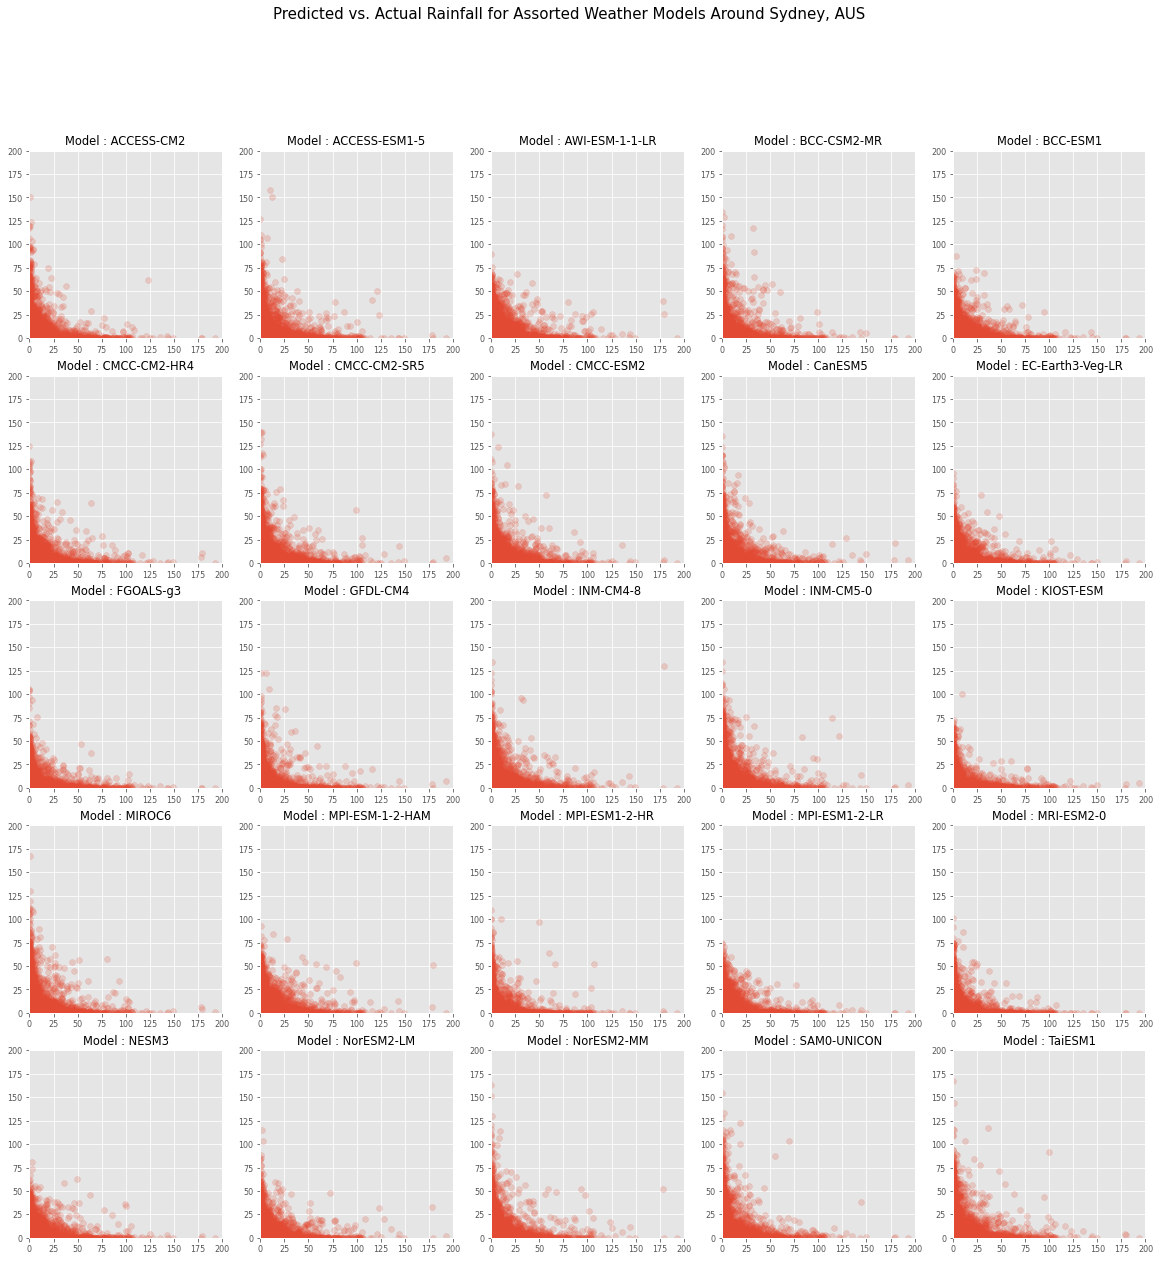

In [41]:
# Quick scatter matrix of predicted vs. actual for every weather model
fig,ax = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
fig.suptitle("Predicted vs. Actual Rainfall for Assorted Weather Models Around Sydney, AUS", fontsize=15)
# fig.get_title().set_fontsize(15)

for i in range(0,25):
    ax[i//5, i % 5].scatter(df_train.iloc[:,25], df_train.iloc[:,i], alpha=0.2)
    ax[i//5, i % 5].set_title(f"Model : {df_train.columns[i]}")
    ax[i//5, i % 5].set_xlim([0, 200])
    ax[i//5, i % 5].set_ylim([0, 200])

We can see there isn't a clear correlation between the underlying model predictions and the rainfall actuals. Let's hope we can clean this up.

In [ ]:
X, y = df_train.iloc[:, 0:-1].values, df_train.iloc[:,-1].values

model = RandomForestRegressor(random_state=42)

param_grid = {"n_estimators":[10,30,50,75,100],
             "max_depth": [5, 10, 30, 50]}

grid_searcher = GridSearchCV(model, param_grid=param_grid, scoring=mean_squared_error, cv=3, refit=True)

grid_searcher.fit(X,y)



/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=[1.8330437  4.0381827  0.41981775 ... 0.00514131 0.04484289 0.32425106] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    return f(**kwargs)
  File "/opt/tljh/user/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 336, in mean_squared_error
    y_true, y_pred, 

/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=[1.6690423e-01 2.8455470e+00 0.0000000e+00 ... 1.4684340e-03 2.6762451e+01
 4.5578900e-02] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    return f(**kwargs)
  File "/opt/tljh/user/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 336, in mean_squared_error
 

/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=[1.8012911e-01 0.0000000e+00 4.6316710e-02 ... 5.5524960e+01 1.7595340e+00
 1.7918755e+00] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    return f(**kwargs)
  File "/opt/tljh/user/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 336, in mean_squared_error
 

/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=[1.8330437  4.0381827  0.41981775 ... 0.00514131 0.04484289 0.32425106] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    return f(**kwargs)
  File "/opt/tljh/user/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 336, in mean_squared_error
    y_true, y_pred, 

/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=[1.6690423e-01 2.8455470e+00 0.0000000e+00 ... 1.4684340e-03 2.6762451e+01
 4.5578900e-02] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    return f(**kwargs)
  File "/opt/tljh/user/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 336, in mean_squared_error
 